# Data Analytics Project - Models

# Pair 1 - HEROMOTOCO Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 1 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair1/Pair1_orders.csv')
orders_df.head()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
0,2018-09-04,3184.149902,2735.550049,448.599854,2.186180,SHORT
1,2018-09-05,3145.399902,2772.300049,373.099854,1.220189,FLAT
2,2018-09-06,3164.850098,2783.100098,381.750000,1.330864,FLAT
3,2018-09-07,3329.350098,2923.550049,405.800049,1.638574,SHORT
4,2018-09-10,3278.300049,2868.600098,409.699951,1.688472,SHORT


In [3]:
orders_df.tail()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
54,2018-11-27,2958.149902,2599.649902,358.500000,1.033390,FLAT
55,2018-11-28,2999.149902,2603.899902,395.250000,1.503591,SHORT
56,2018-11-29,3016.800049,2724.000000,292.800049,0.192787,FLAT
57,2018-11-30,3055.199951,2745.699951,309.500000,0.406456,FLAT
58,2018-12-03,3039.899902,2736.000000,303.899902,0.334805,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

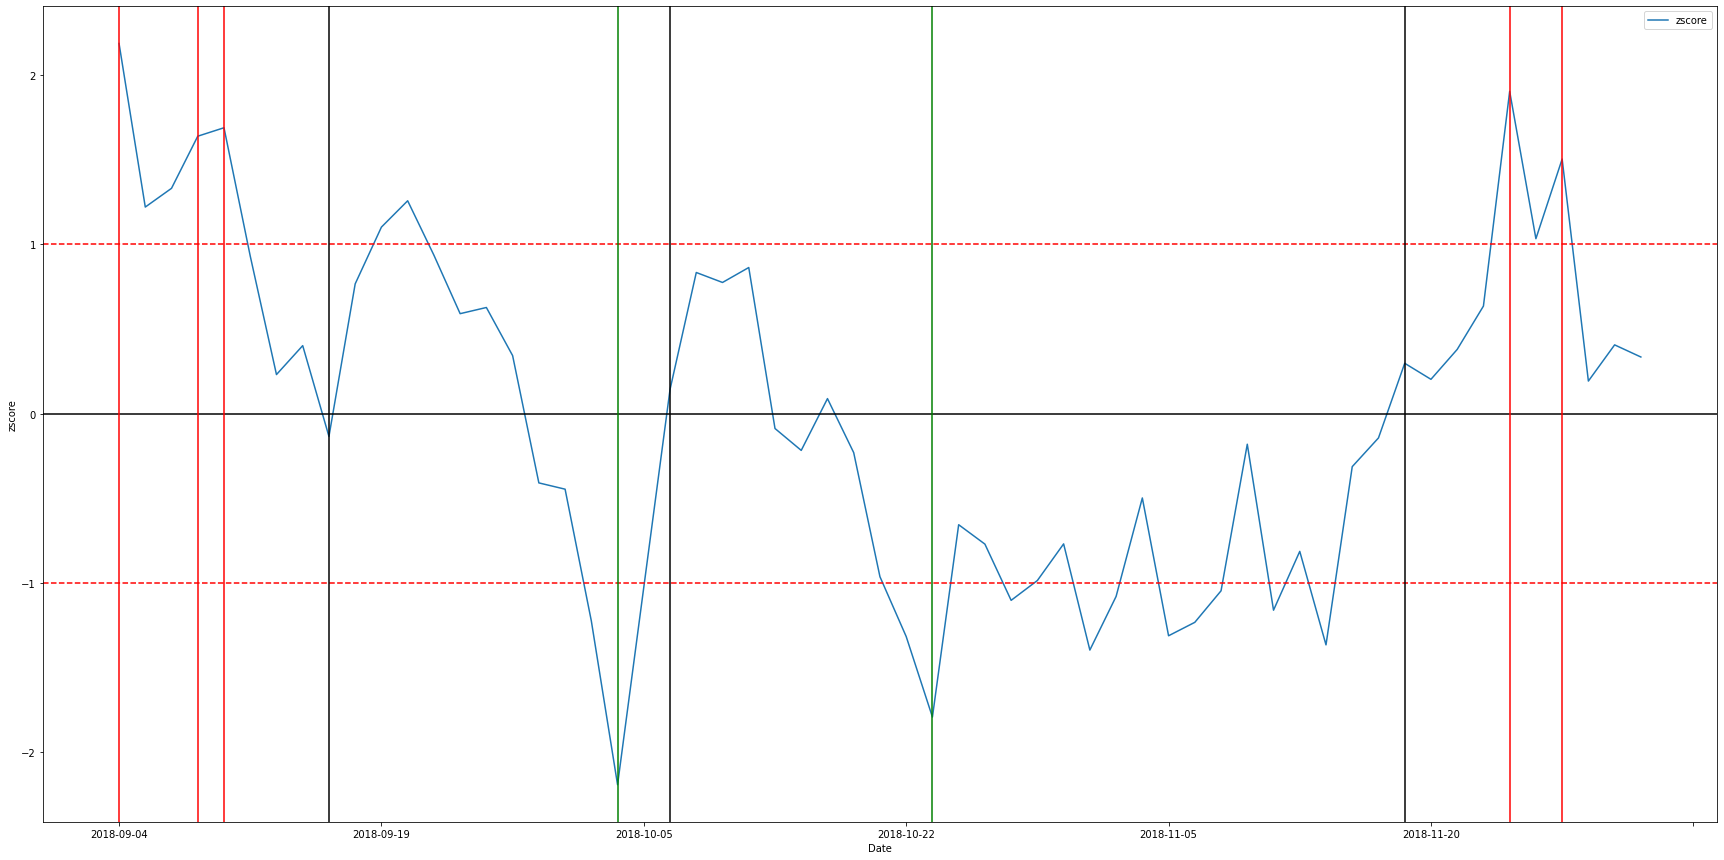

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

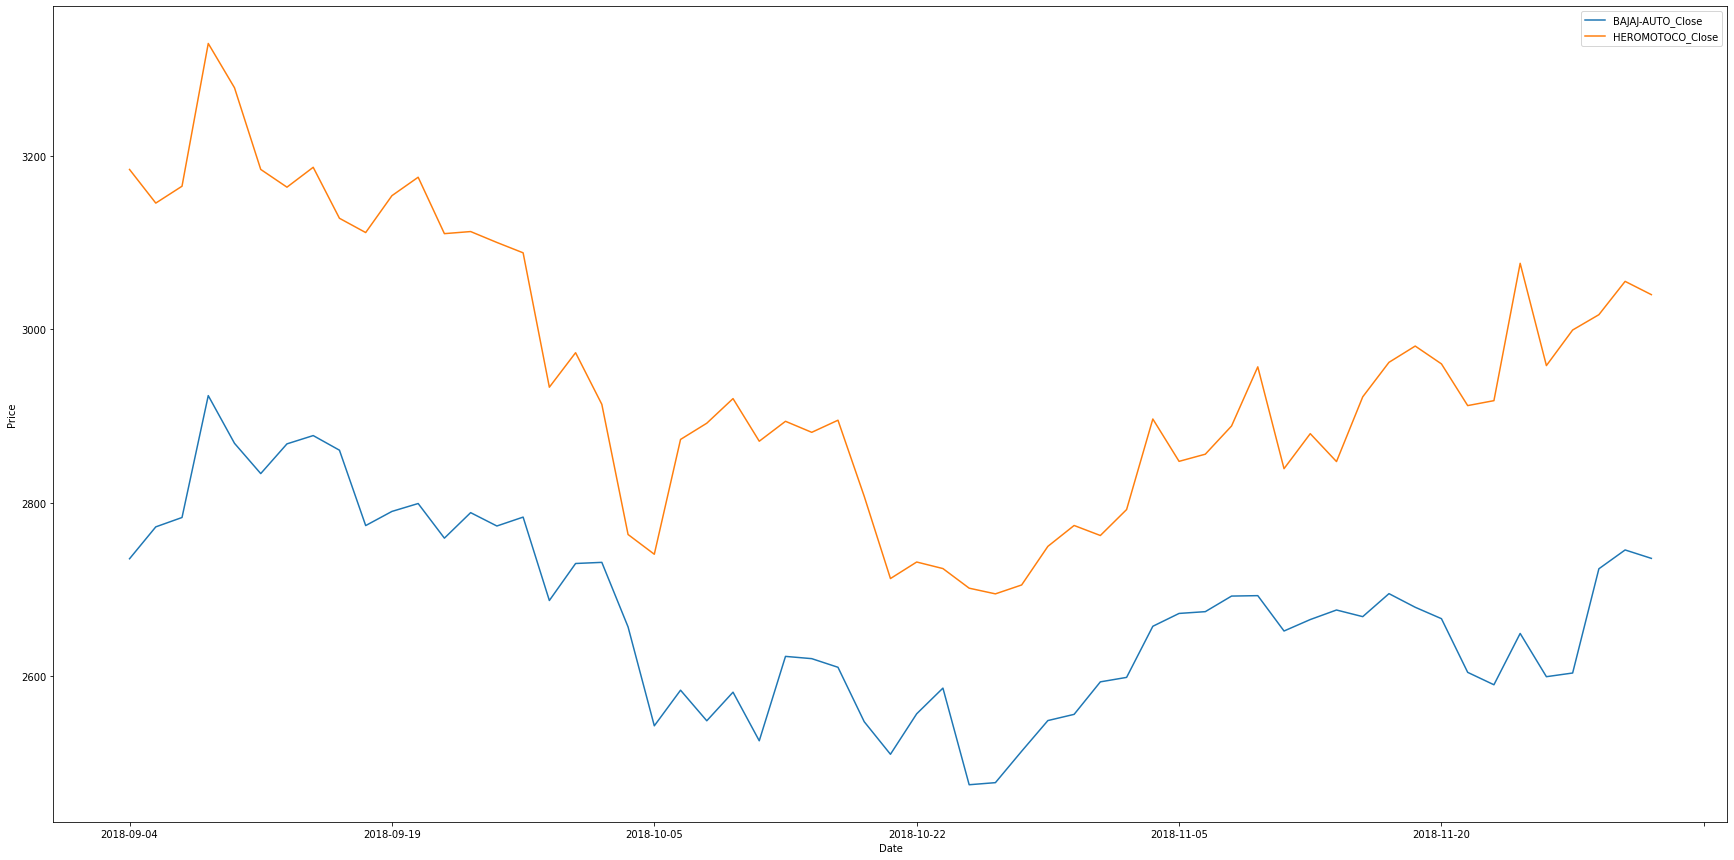

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['BAJAJ-AUTO_Close', 'HEROMOTOCO_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. HEROMOTOCO Linear Regression Model

## 3.1. Get the Complete HEROMOTOCO dataset

In [6]:
hero_df = pd.read_csv("../../Storage/Companies_with_names_exchange/HEROMOTOCONSE.csv")
hero_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,3068.949951,2992.550049,3042.000000,3030.550049,213654.0,2625.101074,HEROMOTOCO,NSE
1,2017-01-03,3016.149902,2962.550049,2978.000000,2986.550049,454277.0,2586.987549,HEROMOTOCO,NSE
2,2017-01-04,3017.300049,2971.000000,2999.000000,3004.899902,396816.0,2602.882568,HEROMOTOCO,NSE
3,2017-01-05,3083.800049,3012.949951,3034.899902,3071.750000,383925.0,2660.788574,HEROMOTOCO,NSE
4,2017-01-06,3119.000000,3052.000000,3085.000000,3067.550049,266915.0,2657.150635,HEROMOTOCO,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get HEROMOTOCO training data

### 3.2.1 Get complete hero dataset

In [7]:
hero_df = hero_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
hero_df.head()

,Date,Close
0,2017-01-02,3030.550049
1,2017-01-03,2986.550049
2,2017-01-04,3004.899902
3,2017-01-05,3071.750000
4,2017-01-06,3067.550049


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
hero_df_train = hero_df[hero_df['Date'] >= '2017-09-03']
hero_df_train.head()

,Date,Close
166,2017-09-04,3978.899902
167,2017-09-05,3970.449951
168,2017-09-06,3950.649902
169,2017-09-07,3982.899902
170,2017-09-08,3956.050049


In [9]:
hero_df_train = hero_df_train[hero_df_train['Date'] <= '2018-09-04']
hero_df_train.tail()

,Date,Close
412,2018-08-29,3246.100098
413,2018-08-30,3223.699951
414,2018-08-31,3253.800049
415,2018-09-03,3242.449951
416,2018-09-04,3184.149902


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(hero_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,3978.899902,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,3970.449951,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,3950.649902,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,3982.899902,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,3956.050049,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,3246.100098,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,3223.699951,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,3253.800049,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,3242.449951,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
hero_train_X = hero_df_train.copy()

In [12]:
hero_train_X = hero_train_X.reset_index(drop=True)
hero_train_X_plot = hero_train_X.copy()
hero_train_X = hero_train_X.drop(columns=["Elapsed", "Close"])
hero_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
hero_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
hero_train_y = hero_df[(hero_df['Date'] >= '2017-09-04') & (hero_df['Date'] <= '2018-09-04')]['Close']
hero_train_y

166    3978.899902
167    3970.449951
168    3950.649902
169    3982.899902
170    3956.050049
          ...     
412    3246.100098
413    3223.699951
414    3253.800049
415    3242.449951
416    3184.149902
Name: Close, Length: 251, dtype: float64

In [15]:
len(hero_train_X)

251

In [16]:
len(hero_train_y)

251

## 3.3. Get HEROMOTOCO Test Data

In [17]:
hero_test_df = orders_df.copy()
hero_test_df = hero_df[(hero_df['Date'] >= '2018-09-04') & (hero_df['Date'] <= '2018-12-03')].copy()
hero_test_df.head()

,Date,Close
416,2018-09-04,3184.149902
417,2018-09-05,3145.399902
418,2018-09-06,3164.850098
419,2018-09-07,3329.350098
420,2018-09-10,3278.300049


In [18]:
hero_test_df.tail()

,Date,Close
470,2018-11-27,2958.149902
471,2018-11-28,2999.149902
472,2018-11-29,3016.800049
473,2018-11-30,3055.199951
474,2018-12-03,3039.899902


In [19]:
add_datepart(hero_test_df, 'Date')
hero_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,3184.149902,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,3145.399902,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,3164.850098,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,3329.350098,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,3278.300049,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
hero_test_X = hero_test_df.copy()
hero_test_X = hero_test_X.drop(columns=['Close', "Elapsed"])
hero_test_X.reset_index(drop=True, inplace=True)
hero_test_X.index += 251
hero_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
hero_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
hero_test_y = hero_df[(hero_df['Date'] >= '2018-09-04') & (hero_df['Date'] <= '2018-12-03')]
hero_test_y.reset_index(drop=True, inplace=True)
hero_test_y.index += 251
hero_test_y = hero_test_y['Close']

In [23]:
hero_test_y

251    3184.149902
252    3145.399902
253    3164.850098
254    3329.350098
255    3278.300049
256    3184.199951
257    3163.750000
258    3186.649902
259    3127.899902
260    3111.449951
261    3153.949951
262    3175.199951
263    3110.199951
264    3112.600098
265    3100.050049
266    3088.100098
267    2933.250000
268    2973.000000
269    2913.500000
270    2763.500000
271    2740.750000
272    2873.050049
273    2891.750000
274    2920.100098
275    2871.000000
276    2893.949951
277    2881.250000
278    2895.199951
279    2807.550049
280    2712.750000
281    2731.800049
282    2724.250000
283    2701.649902
284    2695.100098
285    2705.350098
286    2749.850098
287    2773.899902
288    2762.350098
289    2792.250000
290    2896.600098
291    2847.800049
292    2856.050049
293    2888.550049
294    2956.699951
295    2839.350098
296    2879.699951
297    2847.550049
298    2922.149902
299    2961.899902
300    2980.649902
301    2960.100098
302    2912.050049
303    2917.

In [24]:
len(hero_test_X)

59

In [25]:
len(hero_test_y)

59

## 3.4 Create and Train HEROMOTOCO Model

In [26]:
model = LinearRegression()
model = model.fit(hero_train_X, hero_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(hero_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,3275.607148
252,3271.913457
253,3268.219767
254,3264.526076
255,3257.640557
256,3253.946866
257,3250.253176
258,3242.865795
259,3235.980276
260,3232.286585


In [28]:
predictions_df['test_data'] = hero_test_y
predictions_df

,predictions,test_data
251,3275.607148,3184.149902
252,3271.913457,3145.399902
253,3268.219767,3164.850098
254,3264.526076,3329.350098
255,3257.640557,3278.300049
256,3253.946866,3184.199951
257,3250.253176,3163.750000
258,3242.865795,3186.649902
259,3235.980276,3127.899902
260,3232.286585,3111.449951


In [29]:
predictions = predictions_df['predictions']
predictions

251    3275.607148
252    3271.913457
253    3268.219767
254    3264.526076
255    3257.640557
256    3253.946866
257    3250.253176
258    3242.865795
259    3235.980276
260    3232.286585
261    3228.592895
262    3221.205514
263    3214.319995
264    3210.626304
265    3206.932614
266    3203.238923
267    3199.545233
268    3256.183242
269    3247.717000
270    3244.023309
271    3240.329619
272    3233.444100
273    3229.750409
274    3226.056719
275    3222.363028
276    3218.669338
277    3211.783819
278    3208.090128
279    3204.396438
280    3197.009056
281    3190.123538
282    3186.429847
283    3182.736156
284    3179.042466
285    3175.348775
286    3168.463256
287    3164.769566
288    3195.141256
289    3143.755481
290    3149.624329
291    3142.738810
292    3139.045119
293    3135.351429
294    3127.964047
295    3121.078529
296    3117.384838
297    3113.691147
298    3109.997457
299    3106.303766
300    3099.418247
301    3095.724557
302    3092.030866
303    3088.

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(hero_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(hero_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(hero_test_y, predictions)))
print('R2 Score:', metrics.r2_score(hero_test_y, predictions))

Mean Absolute Error: 232.9177233646308
Mean Squared Error: 76263.76978080526
Root Mean Squared Error: 276.15895745169166
R2 Score: -2.01603459510396


## 3.6. Visualize the predicitons vs test data

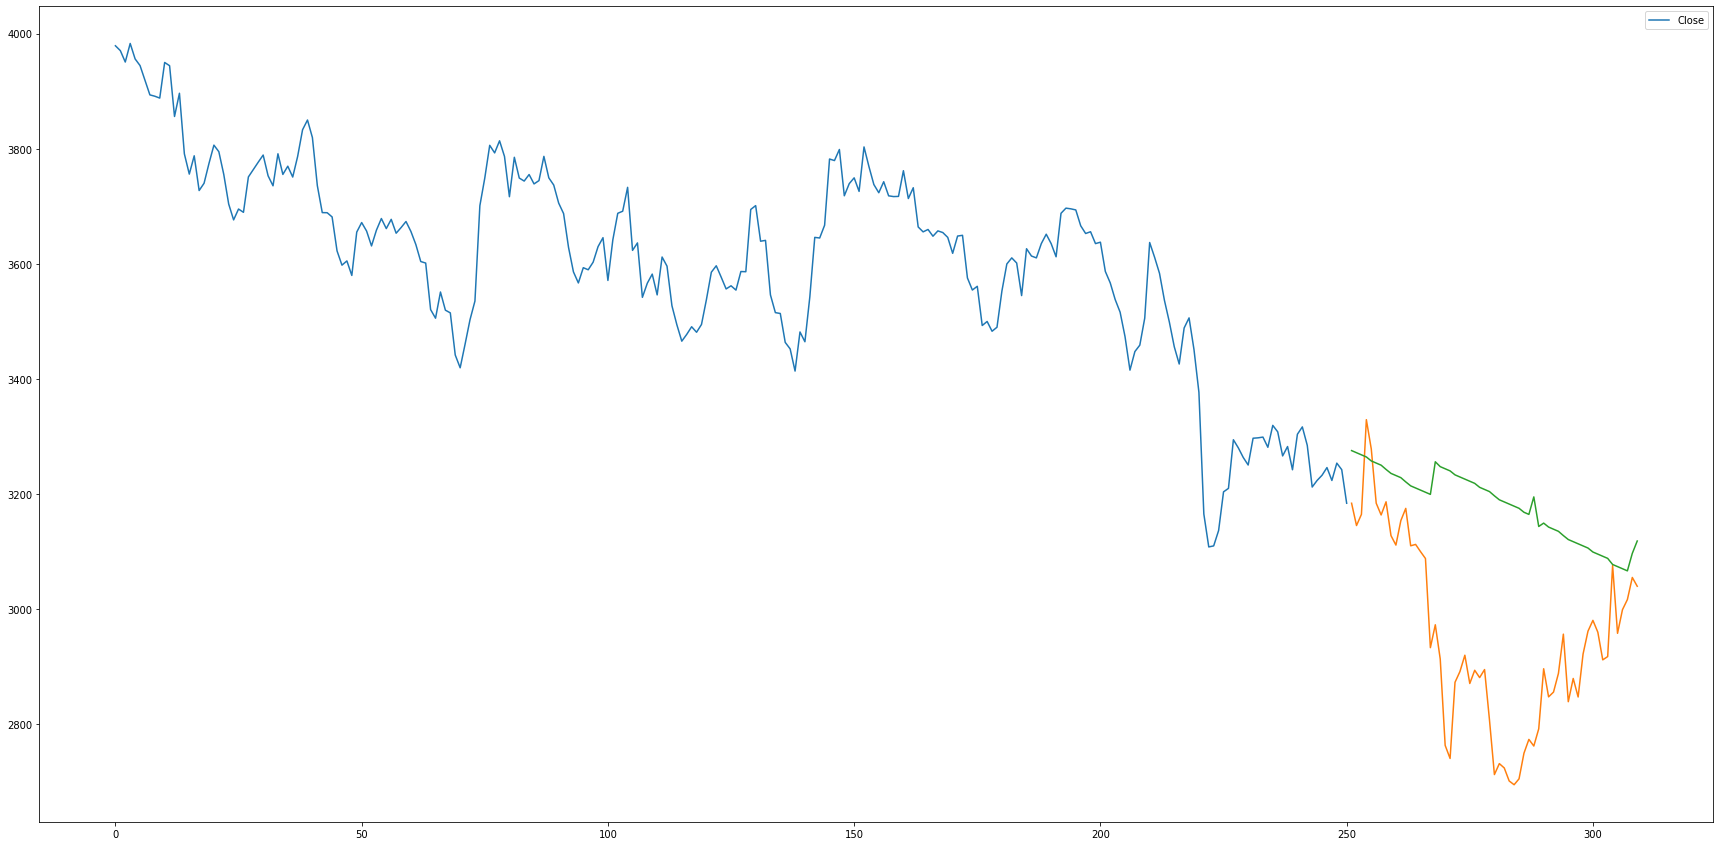

In [31]:
hero_model_plt = hero_train_X_plot.plot(y=['Close'], figsize=(30,15))
hero_model_plt.plot(predictions_df['test_data'])
hero_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
hero_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['HEROMOTOCO_Close']}
hero_predictions_df = pd.DataFrame(hero_predictions_data)
hero_predictions_df.head()

,Date,Actual_Close
0,2018-09-04,3184.149902
1,2018-09-05,3145.399902
2,2018-09-06,3164.850098
3,2018-09-07,3329.350098
4,2018-09-10,3278.300049


In [33]:
predictions_df = predictions_df.reset_index()
hero_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
hero_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-09-04,3184.149902,3275.607148
1,2018-09-05,3145.399902,3271.913457
2,2018-09-06,3164.850098,3268.219767
3,2018-09-07,3329.350098,3264.526076
4,2018-09-10,3278.300049,3257.640557


In [34]:
hero_predictions_df.to_csv('Hero_predicitions.csv', index=False)